# Circuit implementation of quantum counting algorithm using TheQ

This notebook will teach you how to construct your own circuits for quantum counting algorithm using TheQ.

# Importing packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
import numpy as np # For playing around with pi
import matplotlib.pyplot as plt # For plotting functions
from google.colab import files

#req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str = 'http://8fc11588c850.ngrok.io/qsim/perform_operation'
#req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'
req_str_qasm = 'http://8fc11588c850.ngrok.io/qsim/qasm'

# Required functions

These are some required functions to run any circuit in TheQ.

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']

def Toffoli(q0, q1, q2):
  gate(reg_id, 'hadamard', {'q': q2})
  gate(reg_id, 'cnot', {'q_control': q1, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': -np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q1, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q2, 'theta': np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q2})
  gate(reg_id, 'zrot', {'q': q1, 'theta': np.pi/4})
  gate(reg_id, 'zrot', {'q': q2, 'theta': -np.pi/4})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q1})
  gate(reg_id, 'zrot', {'q': q1, 'theta': np.pi/4})
  gate(reg_id, 'hadamard', {'q': q2})
  gate(reg_id, 'cnot', {'q_control': q0, 'q_target': q1})
  gate(reg_id, 'zrot', {'q': q0, 'theta': -np.pi/4})
  gate(reg_id, 'zrot', {'q': q1, 'theta': -np.pi/2})

def controlled_hadamard(control_qubit, target_qubit):
  gate(reg_id, 'zrot', {'q': target_qubit, 'theta': -np.pi/2})
  gate(reg_id, 'zrot', {'q': target_qubit, 'theta': -np.pi/4})
  gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': target_qubit})
  gate(reg_id, 'zrot', {'q': target_qubit, 'theta': np.pi/4})
  gate(reg_id, 'yrot', {'q': target_qubit, 'theta': np.pi/4})
  gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': target_qubit})
  gate(reg_id, 'yrot', {'q': target_qubit, 'theta': -np.pi/4})
  gate(reg_id, 'zrot', {'q': control_qubit, 'theta': -np.pi/2})


#The circuit

Now we move on to the main part of the notebook. In this section, we shall explain the construction of quantum counting circuits. The problem setting is as follows; let $f: \{ 0, 1, \dots, N-1\} \rightarrow \{ 0, 1\}$. Our objective is to count the number of distinct elements $\omega$ in the domain such that $f(\omega)=1$, with minimum number of queries to the function $f$. The quantum counting algorithm solves the problem by combining Grover's search and phase estimation algorithm. Let $G$ be the Grover iterate, that is, $G=U_s U_{\omega}$. The quantum counting circuit is nothing but phase estimation carries out with the operator $G$, and the state $|+\rangle ^ {\otimes \log N}$ prepare in the register where the eigenvectors are prepared. So, the final circuit, with precision of $t$ qubits, is as follows: 

From the measurement output $\phi$, first we compute the eigenvalue of $G$, which is $\lambda =  \frac{2 \pi \phi}{2 ^ t}$. The approximation of the number of satisfiable elements in the domain is given as $N \sin ^ 2 \lambda$.

# Example 1

In this example, consider the function $f: \{ 0,1,2,3\} \rightarrow \{ 0,1\} $ given as

\begin{equation}
  f(x) = 
  \begin{cases}
    1 & \text{ if }x = 1 \ \& \ x = 3 \\
    0 & \text{ otherwise }
  \end{cases}
\end{equation}

This function has two satisfiable solutions $1$ and $3$. In this case $U_{\omega}$ should be an operator of the form

\begin{equation}
  U|x_1 x_2\rangle = 
  \begin{cases}
    -|x_1 x_2 \rangle & \text{ if }x_1 = 1 \\
    |x_1 x_2 \rangle & \text{ otherwise }
  \end{cases}
\end{equation}

This is actually a $Z$ gate applied on the qubit $x_1$.


One can see that the operator $U_s$ does not depend on the function $f$ and it depends only on $N$. When $N=4$ ($2$-qubit case), the circuit for $U_s$ can be seen as

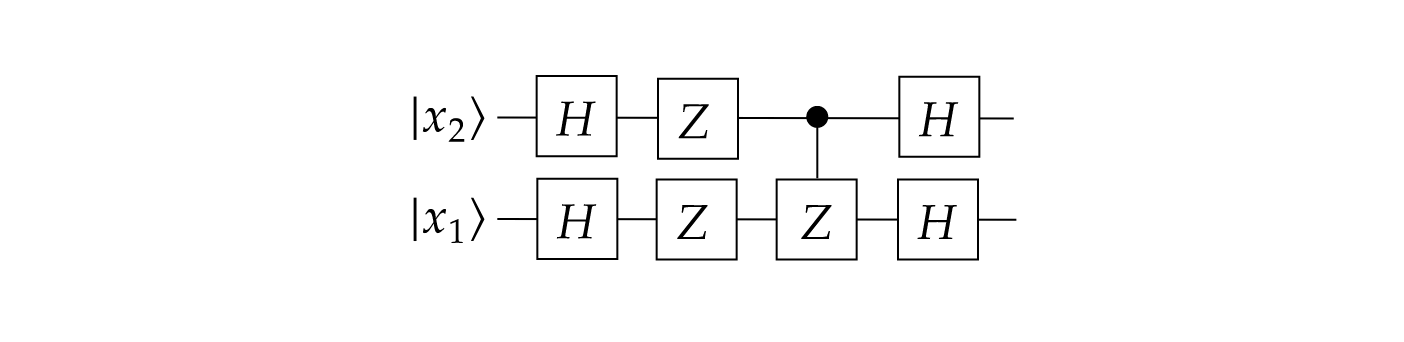

Then, with $2$-qubits in the first register, the final circuit will have the form

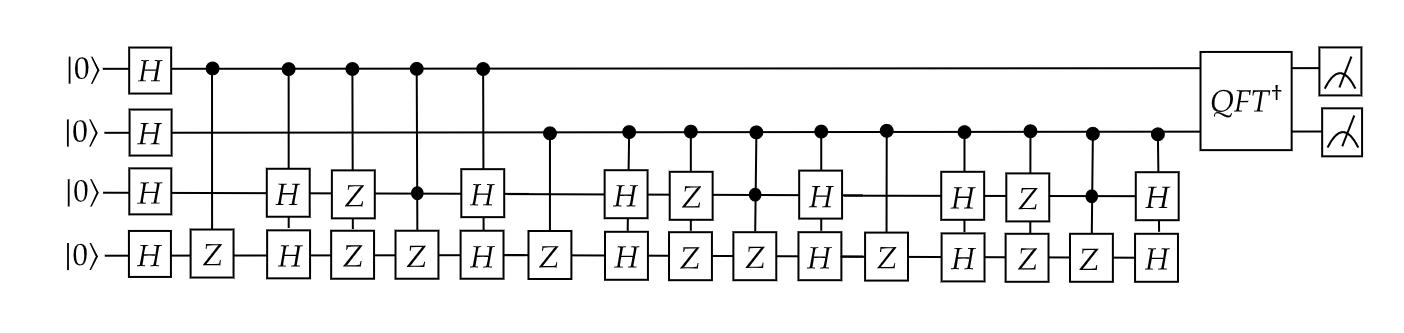

Now, we move on to constructing this circuit using TheQ.

Since the circuit contains $4$ qubits, we create a circuit with $4$ qubits.

In [ ]:
  # Prepare the circuit
  reg_id = create_circuit(4,0)

Now, we shall start applying the gates.

Apply Hadamard gates on all qubits

In [ ]:
# Apply Hadamard gate on all qubits
for i in range(4):
  gate(reg_id, 'hadamard', {'q': i})

Now, we shall start applying controlled-$G ^ {2 ^ j}$ gates.

In [ ]:
for control_qubit in range(2):
  for j in range(2 ** control_qubit):

    # Apply controlled-U_s
    gate(reg_id, 'hadamard', {'q': 3})
    gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 3})
    gate(reg_id, 'hadamard', {'q': 3})

    # Apply controlled-U_w
    controlled_hadamard(control_qubit, 2)
    controlled_hadamard(control_qubit, 3)            

    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 2})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'hadamard', {'q': 3})
    gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 3})
    gate(reg_id, 'hadamard', {'q': 3})

    gate(reg_id, 'hadamard', {'q': 3})
    Toffoli(control_qubit, 2, 3)
    gate(reg_id, 'hadamard', {'q': 3})
    
    controlled_hadamard(control_qubit, 2)
    controlled_hadamard(control_qubit, 3)


The next part is the inverse quantum Fourier transform part.

In [ ]:
# Apply swap gates
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 0})
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

# Apply controlled-Rk inverse gates
for target_qubit in range(2):
  for control_qubit in range(target_qubit):
    gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
  gate(reg_id, 'hadamard', {'q': target_qubit})


Now, we shall measure, simulate the circuit $100$ times and analyze the result.

In [ ]:
# Measure the qubits 0,1
c0 = measure_qubit(reg_id,{'lq2m': list(range(1,-1,-1))})
print(c0)

# Destroy circuit
destroy_circuit(reg_id)

In [ ]:
i = 0
results = {}

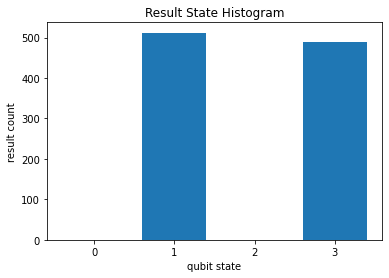

In [ ]:
while i < 100:

  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Apply Hadamard gate on all qubits
  for i in range(4):
    gate(reg_id, 'hadamard', {'q': i})

  for control_qubit in range(2):
    for j in range(2 ** control_qubit):

      # Apply controlled-U_s
      gate(reg_id, 'hadamard', {'q': 3})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 3})
      gate(reg_id, 'hadamard', {'q': 3})

      # Apply controlled-U_w
      controlled_hadamard(control_qubit, 2)
      controlled_hadamard(control_qubit, 3)            

      gate(reg_id, 'hadamard', {'q': 2})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 2})
      gate(reg_id, 'hadamard', {'q': 2})

      gate(reg_id, 'hadamard', {'q': 3})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 3})
      gate(reg_id, 'hadamard', {'q': 3})

      gate(reg_id, 'hadamard', {'q': 3})
      Toffoli(control_qubit, 2, 3)
      gate(reg_id, 'hadamard', {'q': 3})
      
      controlled_hadamard(control_qubit, 2)
      controlled_hadamard(control_qubit, 3)
      
  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(2):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(1,-1,-1))})
  

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1

  destroy_circuit(reg_id)
  i += 1

  

In [ ]:
# Plot the results 
f =plt.figure()
plt.plot(x, y)
f.set_figwidth(20)
f.set_figheight(5)
plt.bar(results.keys(), results.values(), color='g')
plt.xticks(list(range(16)))
plt.show()

The outputs $1$ and $3$ seem to be equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(1 * np.pi/4) ** 2)))
print("Value suggested by output 3: {}".format(4 * (np.sin(3 * np.pi/4) ** 2)))

Value suggested by output 1: 1.9999999999999996
Value suggested by output 3: 2.0000000000000004


Both measurement outputs point to the correct answer $2$.

# Example 2

In this example, consider the function $f: \{ 0,1,2,3\} \rightarrow \{ 0,1\} $ given as

\begin{equation}
  f(x) = 
  \begin{cases}
    1 & \text{ if }x = 3 \\
    0 & \text{ otherwise }
  \end{cases}
\end{equation}

This function has one satisfiable solution $3$. In this case $U_{\omega}$ should be an operator of the form

\begin{equation}
  U|x_1 x_2\rangle = 
  \begin{cases}
    -|x_1 x_2 \rangle & \text{ if }x_1 = 1 \ \& \ x_2 = 1\\
    |x_1 x_2 \rangle & \text{ otherwise }
  \end{cases}
\end{equation}

This is the controlled-$Z$ gate. Since $U_s$ does not depend upon $f$, we can use the same $U_s$ used in the previous case.


## $3$-qubit precision

In this section, we carry out the quantum counting circuit, with $3$-qubit precision. `

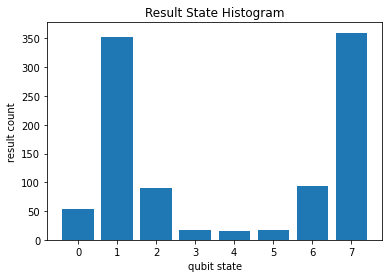

In [ ]:
while i < 100:

  # Prepare the circuit
  reg_id = create_circuit(5,0)

  # Apply Hadamard gate on all qubits
  for i in range(5):
    gate(reg_id, 'hadamard', {'q': i})

  for control_qubit in range(3):
    for j in range(2 ** control_qubit):

      # Apply controlled-U_s
      gate(reg_id, 'hadamard', {'q': 4})
      Toffoli(control_qubit, 3, 4)
      gate(reg_id, 'hadamard', {'q': 4})

      # Apply controlled-U_w
      controlled_hadamard(control_qubit, 3)
      controlled_hadamard(control_qubit, 4)            

      gate(reg_id, 'hadamard', {'q': 3})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 3})
      gate(reg_id, 'hadamard', {'q': 3})

      gate(reg_id, 'hadamard', {'q': 4})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 4})
      gate(reg_id, 'hadamard', {'q': 4})

      gate(reg_id, 'hadamard', {'q': 4})
      Toffoli(control_qubit, 3, 4)
      gate(reg_id, 'hadamard', {'q': 4})
      
      controlled_hadamard(control_qubit, 3)
      controlled_hadamard(control_qubit, 4)
      
  # Apply QFT
  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 2})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 2})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(3):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(2,-1,-1))})
  

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1


  destroy_circuit(reg_id)
  i += 1

  

The outputs $1$ and $7$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(1 * np.pi/8) ** 2)))
print("Value suggested by output 7: {}".format(4 * (np.sin(7 * np.pi/8) ** 2)))

Value suggested by output 1: 0.585786437626905
Value suggested by output 7: 0.5857864376269053


In this case, we are approximately $0.42$ away from the correct answer $1$. Let's see if we can closer to the correct answer by adding more qubits for precision.

## $4$-qubit precision

In the next cell, we run the same phase estimation with $4$ qubit precision.

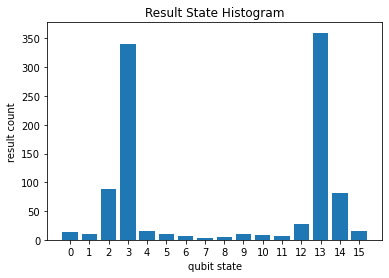

In [ ]:
while i < 100:

  # Prepare the circuit
  reg_id = create_circuit(6,0)

  # Apply Hadamard gate on all qubits
  for i in range(6):
    gate(reg_id, 'hadamard', {'q': i})

  for control_qubit in range(4):
    for j in range(2 ** control_qubit):

      # Apply controlled-U_s
      gate(reg_id, 'hadamard', {'q': 5})
      Toffoli(control_qubit, 4, 5)
      gate(reg_id, 'hadamard', {'q': 5})

      # Apply controlled-U_w
      controlled_hadamard(control_qubit, 4)
      controlled_hadamard(control_qubit, 5)            

      gate(reg_id, 'hadamard', {'q': 4})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 4})
      gate(reg_id, 'hadamard', {'q': 4})

      gate(reg_id, 'hadamard', {'q': 5})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 5})
      gate(reg_id, 'hadamard', {'q': 5})

      gate(reg_id, 'hadamard', {'q': 5})
      Toffoli(control_qubit, 4, 5)
      gate(reg_id, 'hadamard', {'q': 5})
      
      controlled_hadamard(control_qubit, 4)
      controlled_hadamard(control_qubit, 5)
      
  # Apply QFT
  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 1})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 2})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(4):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(3,-1,-1))})
  

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1


  destroy_circuit(reg_id)
  i += 1

  

The outputs $3$ and $13$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(3 * np.pi/16) ** 2)))
print("Value suggested by output 7: {}".format(4 * (np.sin(13 * np.pi/16) ** 2)))

Value suggested by output 1: 1.2346331352698203
Value suggested by output 7: 1.2346331352698203


In this case, we are approximately $0.23$ away from the correct answer $1$. Let's see if we can closer to the correct answer by adding more qubits for precision.

##$5$-qubit precision

In the next cell, we run the same phase estimation with $5$ qubit precision.

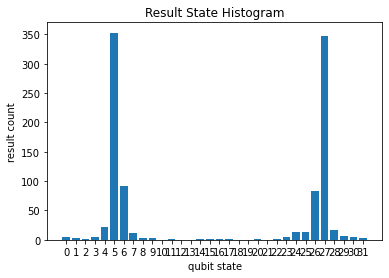

In [ ]:
while i < 100:

  # Prepare the circuit
  reg_id = create_circuit(7,0)

  # Apply Hadamard gate on all qubits
  for i in range(7):
    gate(reg_id, 'hadamard', {'q': i})

  for control_qubit in range(5):
    for j in range(2 ** control_qubit):

      # Apply controlled-U_s
      gate(reg_id, 'hadamard', {'q': 6})
      Toffoli(control_qubit, 5, 6)
      gate(reg_id, 'hadamard', {'q': 6})

      # Apply controlled-U_w
      controlled_hadamard(control_qubit, 5)
      controlled_hadamard(control_qubit, 6)            

      gate(reg_id, 'hadamard', {'q': 5})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 5})
      gate(reg_id, 'hadamard', {'q': 5})

      gate(reg_id, 'hadamard', {'q': 6})
      gate(reg_id, 'cnot', {'q_control': control_qubit, 'q_target': 6})
      gate(reg_id, 'hadamard', {'q': 6})

      gate(reg_id, 'hadamard', {'q': 6})
      Toffoli(control_qubit, 5, 6)
      gate(reg_id, 'hadamard', {'q': 6})
      
      controlled_hadamard(control_qubit, 5)
      controlled_hadamard(control_qubit, 6)
      
  # Apply QFT
  # Apply swap gates
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 4})
  gate(reg_id, 'cnot', {'q_control': 4, 'q_target': 0})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 4})

  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 3, 'q_target': 1})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})

  # Apply controlled-Rk inverse gates
  for target_qubit in range(5):
    for control_qubit in range(target_qubit):
      gate(reg_id, 'cphase', {'q_control': control_qubit, 'q_target': target_qubit, 'theta': -np.pi/float(2**(target_qubit-control_qubit))})
    gate(reg_id, 'hadamard', {'q': target_qubit})

  c0 = measure_qubit(reg_id,{'lq2m': list(range(4,-1,-1))})
  

  try:
    results[c0] += 1
  except KeyError:
    results[c0] = 1


  destroy_circuit(reg_id)
  i += 1

  

The outputs $5$ and $27$ seem to occur most and equally probable, Now, compute the number of satisfiable elements in the domain from the outputs, in both cases.

In [ ]:
print("Value suggested by output 1: {}".format(4 * (np.sin(5 * np.pi/32) ** 2)))
print("Value suggested by output 7: {}".format(4 * (np.sin(27 * np.pi/32) ** 2)))

Value suggested by output 1: 0.8888595339607955
Value suggested by output 7: 0.8888595339607963


In this case, we are approximately $0.12$ away from the correct answer $1$. 